# Naural Networks

## Załadowanie i przygotowanie danych

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import keras
import tensorflow
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

Wstępne załadowanie i eskploracja oryginalnych danych.

In [77]:
chess = pd.read_csv("Data/games.csv")
chess = chess.loc[:9999, :]
chess.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Zakodowanie godzin na dane z zakresu (0, 1)

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [78]:
hoursAfterMidnight = (chess.loc[:, 'created_at']/1000).apply(datetime.fromtimestamp).dt.hour
chess['sin_created_at'] = np.sin(2*np.pi*hoursAfterMidnight/24)
chess['cos_created_at'] = np.cos(2*np.pi*hoursAfterMidnight/24)

Usunięcie niepotrzebnych kolumn.

In [79]:
chess.drop(columns=['created_at', 'last_move_at', 'victory_status', 'white_id', 'moves', 'black_id', 'opening_name', 'id'], inplace=True)
chess.head()

,rated,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply,sin_created_at,cos_created_at
0,False,13,white,15+2,1500,1191,D10,5,-0.500000,8.660254e-01
1,True,16,black,5+10,1322,1261,B00,4,-0.258819,9.659258e-01
2,True,61,white,5+10,1496,1500,C20,3,-0.258819,9.659258e-01
3,True,61,white,20+0,1439,1454,D02,3,-1.000000,-1.836970e-16
4,True,95,white,30+3,1523,1469,C41,5,-0.866025,5.000000e-01


Przedstawienie na wykresie liczby wygranych białych, czarnych oraz remisów

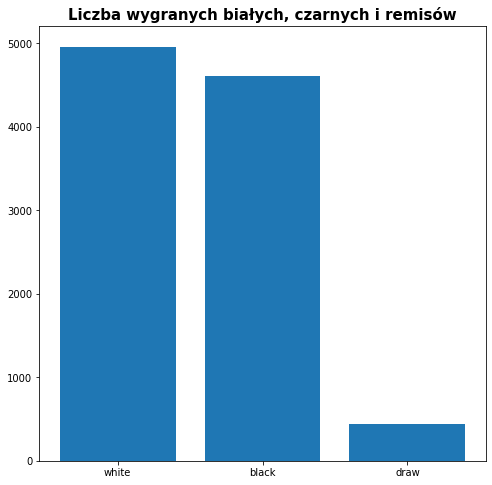

In [80]:
labels = chess.loc[:, "winner"].value_counts().index
values = chess.loc[:, "winner"].value_counts().values
plt.figure(figsize=(8, 8))
plt.bar(labels, values, align="center")
plt.title("Liczba wygranych białych, czarnych i remisów", fontdict={"fontweight": "bold", "size": 15})
plt.show()

Zamiana kolumny rated z Boolen na zero-jedynkową i zakodowanie wartości kategorycznych

In [81]:
chess.loc[:, 'rated'] = chess.loc[:, 'rated']*1
yRaw = chess.loc[:, 'winner']
temp = pd.get_dummies(chess.loc[:, ['increment_code', 'winner', 'opening_eco']])
chess.drop(columns=['increment_code', 'winner', 'opening_eco'], inplace=True)
chess = pd.concat([chess, temp], axis=1)
chess.replace({np.nan, 0})

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-5.000000e-01,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000e+00,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-8.660254e-01,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,63,1195,1369,5,-5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,95,1195,1369,3,1.224647e-16,-1.000000e+00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,76,1195,1247,6,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,1,40,1369,1062,4,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
chess.head()

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-0.500000,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-0.258819,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-0.258819,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-0.866025,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Tworzenie modelu

Artykuł o tworzeniu modelu: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

## Próba przewidzenie czy wygra biały, czarny czy spotkanie zakończy się remisem

Podział na zmienne objąśniające i objaśnianą, oraz podział na zbiór uczący i testowy w stosunku 80/20

In [83]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = chess.loc[:, ['winner_black',	'winner_draw', 'winner_white']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Tworzenie początkowego modelu z jedną warstwą wejściową, jedną ukrytą, oraz jedną wyjściową. Tworzony model będzie typu Sekwencyjnego, czyli do modelu dodajemy kolejne warstwy neuronowe, z wybranymi przez nasa parametrami.

Dense Layer: https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/

Cross_entropy: https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy

In [84]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

Optymalizacja modelu do uczenia przy uzyciu adaptującego optymalizera Adam

In [85]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

Fitowanie modelu

In [86]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 1s 16ms/step - loss: 7.6614 - categorical_accuracy: 0.4900
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 3.3051 - categorical_accuracy: 0.4800
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.6966 - categorical_accuracy: 0.4926
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 1.1753 - categorical_accuracy: 0.5537
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0469 - categorical_accuracy: 0.5297
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.9028 - categorical_accuracy: 0.5458
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8642 - categorical_accuracy: 0.5540
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.8316 - categorical_accuracy: 0.5674
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8158 - categorical_accuracy: 0.5910
Epoch 10/100
8/8

Przedstawienie accuracy dla kazdego ze 100 epchów na wykresie liniowym

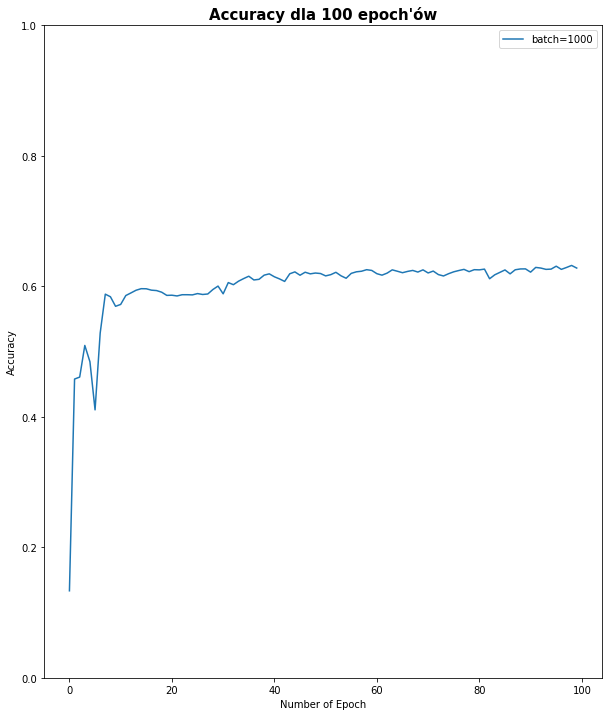

In [15]:
plt.figure(figsize=(10, 12))
plt.title("Accuracy dla 100 epoch'ów", fontdict={"fontweight": "bold", "size": 15})
plt.ylabel("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylim(0, 1)
plt.plot(batch1000.history['categorical_accuracy'], label="batch=1000")
plt.legend()

Artykuł o optymalizacji: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

Funkcja straty: https://www.brutalk.com/pl/wiadomosci/brutalk-blog/przeglad/funkcje-strat-i-strat-do-szkolenia-sieci-neuronowych-uczenia-glebokiego-6046fa42120e8

Artykuł o funkcjach aktywacyjnych: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

Categorical accuracy: https://towardsdatascience.com/keras-accuracy-metrics-8572eb479ec7

### model evaluation

In [16]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.7392 - categorical_accuracy: 0.6325


[0.7392409443855286, 0.6324999928474426]

## Próba przewidzenie czy wygra biały


In [17]:
yWhite = y.loc[:, 'winner_white']
X_train, X_test, y_train, y_test = train_test_split(X, yWhite, test_size=0.2)

In [18]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='softmax'))

In [19]:
opt = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

In [20]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 1s 7ms/step - loss: 7.6578 - binary_accuracy: 0.4983
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 2.6207 - binary_accuracy: 0.4983
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 1.3690 - binary_accuracy: 0.4983
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0055 - binary_accuracy: 0.4983
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.7995 - binary_accuracy: 0.4983
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7056 - binary_accuracy: 0.4983
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6568 - binary_accuracy: 0.4983
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6393 - binary_accuracy: 0.4983
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6350 - binary_accuracy: 0.4983
Epoch 10/100
8/8 [==============================] - 0s 5ms/step 

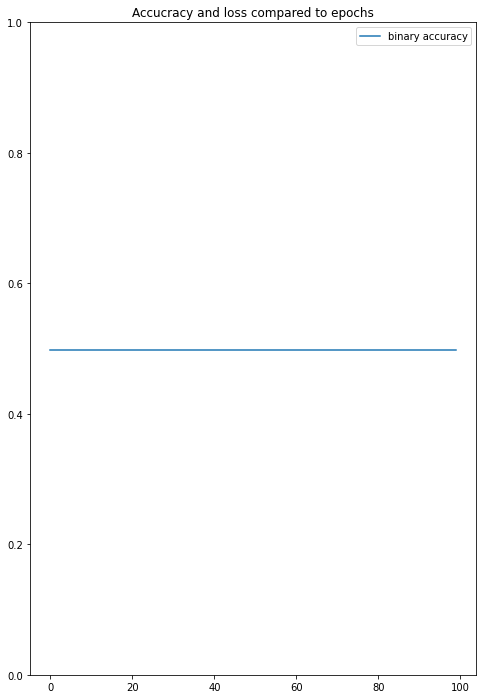

In [21]:
plt.figure(figsize=(8,12))
# plt.plot(batch1000.history['loss'], label="loss")
plt.plot(batch1000.history['binary_accuracy'], label="binary accuracy")
plt.title("Accucracy and loss compared to epochs")
plt.ylim(0, 1)
plt.legend()

In [22]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.6467 - binary_accuracy: 0.4870


[0.6466948986053467, 0.4869999885559082]

Wynik gorszy od początkowego modelu

## Skuteczność modelu w zależności od liczby warstw neuronów i zmian hiperparametrów

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [89]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = yRaw.replace({"white": 0, "black": 1, "draw": 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
def build_clf(unit):
    model = Sequential()
    model.add(Dense(units=unit, input_dim=634, activation='relu'))
    model.add(Dense(units=unit, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

### GridSearch sprawdzanie epochs i batch size.

In [91]:
model = KerasClassifier(build_fn=build_clf)

params= {"epochs": list(range(20, 120, 40)), 
        "batch_size": [100, 500, 1000, 2000],
        "unit": [8, 16]}

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

/var/folders/6v/9h3mqcyj2ylfrpgzflt3jn2r0000gn/T/ipykernel_51727/1795005770.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [92]:
grid_result = grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [147]:
pd.DataFrame(grid_result.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_unit,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,6.604419,1.484302,1.146819,0.446974,1000,60,8,"{'batch_size': 1000, 'epochs': 60, 'unit': 8}",0.619375,0.604375,0.612500,0.628125,0.606875,0.614250,0.008646,1
0,6.468338,0.159391,0.689224,0.147132,100,20,8,"{'batch_size': 100, 'epochs': 20, 'unit': 8}",0.636250,0.605625,0.588125,0.621250,0.619375,0.614125,0.016224,2
11,14.848223,5.832843,0.830377,0.374133,500,100,16,"{'batch_size': 500, 'epochs': 100, 'unit': 16}",0.615000,0.596875,0.605000,0.633750,0.615625,0.613250,0.012371,3
9,8.669534,1.413328,0.884854,0.132791,500,60,16,"{'batch_size': 500, 'epochs': 60, 'unit': 16}",0.624375,0.582500,0.601875,0.630625,0.620625,0.612000,0.017591,4
16,16.013951,3.739375,1.511432,0.473161,1000,100,8,"{'batch_size': 1000, 'epochs': 100, 'unit': 8}",0.625000,0.600000,0.613125,0.616875,0.594375,0.609875,0.011190,5
15,9.123070,1.309349,1.262756,0.395866,1000,60,16,"{'batch_size': 1000, 'epochs': 60, 'unit': 16}",0.586250,0.600000,0.601250,0.635625,0.622500,0.609125,0.017605,6
21,8.053169,0.918638,1.604843,0.867071,2000,60,16,"{'batch_size': 2000, 'epochs': 60, 'unit': 16}",0.620625,0.575000,0.613750,0.607500,0.621875,0.607750,0.017169,7
7,3.397174,0.153497,0.770518,0.217045,500,20,16,"{'batch_size': 500, 'epochs': 20, 'unit': 16}",0.578750,0.605000,0.592500,0.629375,0.624375,0.606000,0.019025,8
22,16.493957,5.704393,1.460436,0.643394,2000,100,8,"{'batch_size': 2000, 'epochs': 100, 'unit': 8}",0.630625,0.599375,0.590625,0.608750,0.600625,0.606000,0.013588,8
23,16.972932,5.325009,0.733974,0.430169,2000,100,16,"{'batch_size': 2000, 'epochs': 100, 'unit': 16}",0.636250,0.608750,0.600625,0.638750,0.540000,0.604875,0.035704,10


Pressenting results (for binary classification): https://towardsdatascience.com/top-5-metrics-for-evaluating-classification-model-83ede24c7584

### Grid search sprawdzanie liczby neuronów

In [34]:
model = KerasClassifier(build_fn=build_clf)

params= {"epochs": [60], 
        "batch_size": [1000],
        "unit": [8, 16, 32, 64, 128, 256, 512]}

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

/var/folders/6v/9h3mqcyj2ylfrpgzflt3jn2r0000gn/T/ipykernel_51727/2205171290.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [35]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/60
Epoch 1/60
Epoch 1/60
Epoch 1/60
7/7 [==============================] - 1s 6ms/step - loss: 24.9167 - accuracy: 0.4611
Epoch 2/60
7/7 [==============================] - 0s 5ms/step - loss: 9.9994 - accuracy: 0.4558
Epoch 3/60
7/7 [==============================] - 0s 13ms/step - loss: 3.4896 - accuracy: 0.4097
Epoch 4/60
7/7 [==============================] - 1s 18ms/step - loss: 111.2141 - accuracy: 0.0433
Epoch 2/60
7/7 [==============================] - 0s 15ms/step - loss: 2.6807 - accuracy: 0.4759
Epoch 5/60
7/7 [==============================] - 0s 7ms/step - loss: 78.2538 - accuracy: 0.0433
Epoch 3/60
7/7 [==============================] - 0s 11ms/step - loss: 2.1275 - accuracy: 0.4870
Epoch 6/60
7/7 [==============================] - 1s 14ms/step - loss: 6.1158 - accuracy: 0.5541
Epoch 4/60
Epoch 2/60
Epoch 2/60
7/7 [==============================] - 0s 11ms/step - loss: 1.5307 - accuracy: 0.4598
Epoch 7/60
7/7 [==============================] - 0s 10ms/step - loss: 

In [36]:
pd.DataFrame(grid_result.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_unit,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,8.536678,3.069001,1.096276,0.420187,1000,60,16,"{'batch_size': 1000, 'epochs': 60, 'unit': 16}",0.642500,0.622500,0.607500,0.611250,0.614375,0.619625,0.012460,1
3,9.861024,0.588878,2.179325,0.665122,1000,60,64,"{'batch_size': 1000, 'epochs': 60, 'unit': 64}",0.630000,0.608750,0.611250,0.611875,0.613750,0.615125,0.007608,2
2,7.593951,0.751973,1.962783,0.769510,1000,60,32,"{'batch_size': 1000, 'epochs': 60, 'unit': 32}",0.608125,0.623125,0.581875,0.613750,0.605000,0.606375,0.013712,3
0,7.682052,0.263912,0.824966,0.151738,1000,60,8,"{'batch_size': 1000, 'epochs': 60, 'unit': 8}",0.625625,0.611875,0.621875,0.620625,0.486875,0.593375,0.053440,4
4,14.458003,0.941606,1.640513,0.766835,1000,60,128,"{'batch_size': 1000, 'epochs': 60, 'unit': 128}",0.588125,0.572500,0.546875,0.551250,0.556250,0.563000,0.015265,5
6,53.775820,19.734088,1.282457,0.351183,1000,60,512,"{'batch_size': 1000, 'epochs': 60, 'unit': 512}",0.538125,0.508750,0.494375,0.505000,0.583750,0.526000,0.032313,6
5,25.439904,1.388159,1.954289,0.481595,1000,60,256,"{'batch_size': 1000, 'epochs': 60, 'unit': 256}",0.265625,0.456875,0.485000,0.516250,0.571250,0.459000,0.103877,7


### Sprawdzanie wyniku w zalezności od liczby neuronów

Budujemy model z najlepszymi wyznaczonymi parametrami, czyli:
* epochs = 60
* batch_size = 1000
* unit = 16

ale z rónymi liczbami warstw ukrytych. Pierwszy z nich będzie mial 2 warstwy ukryte a drugi 5 wartstw ukrytych.
Porównamy dokładności tych modeli z modelem o jednej warstwie ukrytej.

In [98]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model1 = Sequential()
model1.add(Dense(units=16, input_dim=634, activation='relu'))
model1.add(Dense(units=16, activation='relu'))
model1.add(Dense(units=16, activation='relu'))
model1.add(Dense(units=3, activation='softmax'))
model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model2 = Sequential()
model2.add(Dense(units=16, input_dim=634, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=3, activation='softmax'))
model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [99]:
modelfitted = model1.fit(X_train, y_train, epochs=60, batch_size=1000, use_multiprocessing=True)
model1fitted = model1.fit(X_train, y_train, epochs=60, batch_size=1000, use_multiprocessing=True)
model2fitted = model2.fit(X_train, y_train, epochs=60, batch_size=1000, use_multiprocessing=True)

Epoch 1/60
8/8 [==============================] - 1s 15ms/step - loss: 22.2794 - accuracy: 0.2743
Epoch 2/60
8/8 [==============================] - 0s 7ms/step - loss: 8.4122 - accuracy: 0.2664
Epoch 3/60
8/8 [==============================] - 0s 6ms/step - loss: 1.7501 - accuracy: 0.5055
Epoch 4/60
8/8 [==============================] - 0s 7ms/step - loss: 1.5603 - accuracy: 0.5390
Epoch 5/60
8/8 [==============================] - 0s 7ms/step - loss: 1.4112 - accuracy: 0.5141
Epoch 6/60
8/8 [==============================] - 0s 8ms/step - loss: 1.1823 - accuracy: 0.5266
Epoch 7/60
8/8 [==============================] - 0s 9ms/step - loss: 0.9556 - accuracy: 0.5436
Epoch 8/60
8/8 [==============================] - 0s 12ms/step - loss: 0.9025 - accuracy: 0.5750
Epoch 9/60
8/8 [==============================] - 0s 9ms/step - loss: 0.8682 - accuracy: 0.5905
Epoch 10/60
8/8 [==============================] - 0s 7ms/step - loss: 0.8457 - accuracy: 0.5774
Epoch 11/60
8/8 [===================

Porównanie na wykresie modelu z 1, 2 i 5 warstwami ukrytymi

(0.0, 1.0)

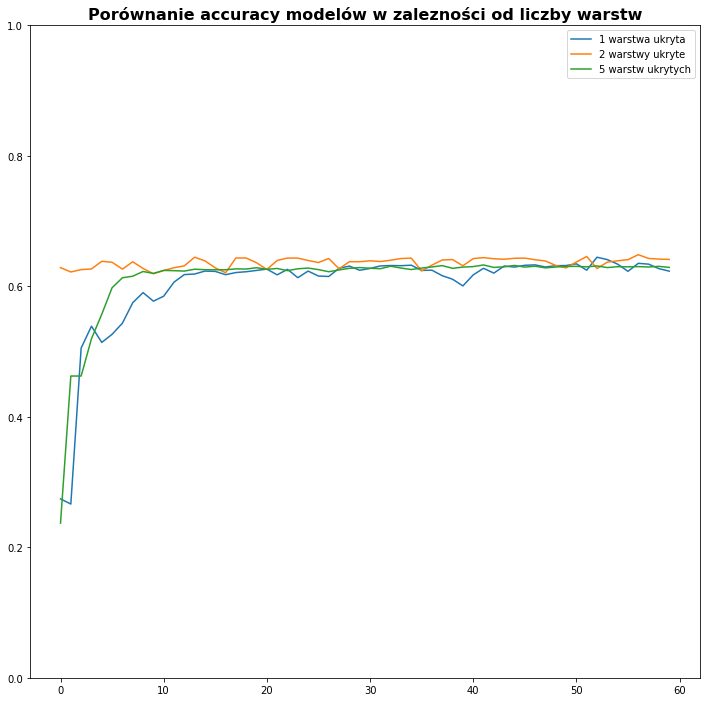

In [100]:
plt.figure(figsize=(12, 12))
plt.plot(modelfitted.history['accuracy'], label="1 warstwa ukryta")
plt.plot(model1fitted.history['accuracy'], label="2 warstwy ukryte")
plt.plot(model2fitted.history['accuracy'], label="5 warstw ukrytych")
plt.title("Porównanie accuracy modelów w zalezności od liczby warstw", fontdict={"fontweight": "bold", "size": 16})
plt.legend()
plt.ylim(0, 1)

Wyniki dokładności modelów

In [40]:
model1.evaluate(X_test, y_test)
model2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.7605 - accuracy: 0.6100


[0.7604817748069763, 0.6100000143051147]